In [1]:
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# when you do the actions, are you accounting for the fact that it changes based on you adding/subtracting
# stuff to fit the gameplay? confirm this please

In [2]:
class Value(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(4, 12) # soft/hard | player | dealer | count
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        return self.lin3(x)
    
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(4, 12) # soft/hard | player | dealer | count
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 8)
        self.softmax = torch.softmax

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        return self.softmax(x, dim = -1)

class CounterPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 12) # c value
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 3) # what
        self.softmax = torch.softmax
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        return self.softmax(x, dim = -1) # -1, 0, +1


class CounterValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 12) 
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        return self.lin3(x)

class BetPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 12) # count
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 6) # 1 to 6 bet spread
        self.softmax = torch.softmax
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        return self.softmax(x, dim = -1)

class BetValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 12) 
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        return self.lin3(x)

In [3]:
def compute_score(hand, new_card, soft):
    """returns score, soft"""
    if new_card >= 2:
        new_hand = hand + new_card

        if soft:
            if new_hand > 21:
                return False, new_hand - 10

            return True, new_hand

        return False, new_hand # then necessarily not soft, with the corresponding sum

    # else, the new hand is with 1 or 11
    new_hand = hand + torch.tensor([[1, 11]])
    valid_indices = (new_hand <= 21)

    # will always be valid indices since we stop at 21 in the other loop :D
    new_score = new_hand[valid_indices].max()

    if valid_indices.sum() == 1:
        return soft, torch.tensor([[new_score]])
        
    return True, torch.tensor([[new_score]])


def remove_card(hand):
    if hand.item() == 12:
        return True, hand - 1

    return False, hand / 2

""" troubleshooting
for i in range(8, 21):
    for j in range(1, 11):
        print()
        print('soft', i, 'with new', j, '===', compute_score(torch.tensor([[i]]), j, True))
        print()
        print('hard', i, 'with new', j, '===', compute_score(torch.tensor([[i]]), j, False))
"""

" troubleshooting\nfor i in range(8, 21):\n    for j in range(1, 11):\n        print()\n        print('soft', i, 'with new', j, '===', compute_score(torch.tensor([[i]]), j, True))\n        print()\n        print('hard', i, 'with new', j, '===', compute_score(torch.tensor([[i]]), j, False))\n"

In [4]:
"""
if action says split and splittable and same_card:
    splittable = False

    # first, get both decks to 1 card
    soft2, player2 = compute_score(player2, second_player_card, soft2)
    soft, player = remove_card(player)

    # add second card to both of these hands
    c = decks.pop(0)
    soft, player = compute_score(player, c, soft)

    counter_probs = policy_counter(torch.tensor([[c]])).detach()
    count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
    count += count_add.item()
    series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

    c = decks.pop(0)
    soft2, player2 = compute_score(player2, c, soft2)

    counter_probs = policy_counter(torch.tensor([[c]])).detach()
    count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
    count += count_add.item()
    series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))
"""

def player_round(decks, soft, player, dealer, count, bet, doubled, same_card, second_player_card, policy, policy_counter, verbose):

    series_of_actions_to_coalesce_at_end = [] # return this so it can be appended 
    series_of_counts_to_coalesce_at_end = []
    
    second_hand = (False, None, None) # it exists, the hand, soft
    splittable = True
    
    while player.item() < 21:

        # ==============
        # get the action 
        # ==============
        state = torch.cat((torch.tensor([[soft]]), player, dealer, torch.tensor([[0.]])), dim = -1) # for now, set this to 0
        prob = policy(state).detach()
        action = torch.distributions.Categorical(probs = prob).sample()

        """
        0 - 3 don't split
            0, 1 don't double
            2, 3 double
        4 - 7 split
            4, 5 don't double
            6, 7 double
        """

        # ==============
        # process the action 
        # ==============
        if action.item() >= 4 and splittable and same_card: # we can split and choose to 
            t = (state, prob, action)
            series_of_actions_to_coalesce_at_end.append(t)

            # establish second hand
            soft2 = False
            player2 = torch.tensor([[0.]])

            # first, get both decks to 1 card
            soft2, player2 = compute_score(player2, second_player_card, soft2)
            soft, player = remove_card(player)
        
            # add second card to both of these hands
            c = decks.pop(0)
            soft, player = compute_score(player, c, soft)
        
            counter_probs = policy_counter(torch.tensor([[c]])).detach()
            count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
            count += count_add.item()
            series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))
        
            c = decks.pop(0)
            soft2, player2 = compute_score(player2, c, soft2)
        
            counter_probs = policy_counter(torch.tensor([[c]])).detach()
            count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
            count += count_add.item()
            series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

            if verbose:
                print('Splitting...')
                print('Player:', player.item(),'| Dealer:', dealer.item())

            splittable = False
            second_hand = (True, player2, soft2)

        elif action.item() in [2, 3, 6, 7] and doubled:
            t = (state, prob, action)
            series_of_actions_to_coalesce_at_end.append(t)
            
            c = decks.pop(0)
            soft, player = compute_score(player, c, soft)

            counter_probs = policy_counter(torch.tensor([[c]])).detach()
            count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
            count += count_add.item()
            series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

            if verbose:
                print('Doubling...')
                print('Player:', player.item(),'| Dealer:', dealer.item())

            break

        elif action.item() % 2 == 0: # stand
            t = (state, prob, action)
            series_of_actions_to_coalesce_at_end.append(t)
            doubled = False

            if verbose:
                print('Standing...')
                print('Player:', player.item(),'| Dealer:', dealer.item())
            
            break

        else: # hit
            t = (state, prob, action)
            series_of_actions_to_coalesce_at_end.append(t)
            
            c = decks.pop(0)
            soft, player = compute_score(player, c, soft)

            counter_probs = policy_counter(torch.tensor([[c]])).detach()
            count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
            count += count_add.item()
            series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

            if verbose:
                print('Hitting...')
                print('Player:', player.item(),'| Dealer:', dealer.item())

            doubled = False
            splittable = False

    # player, count, bet, second hand, series_counts, series_actions
    return player, count, bet * (1 + doubled), second_hand, series_of_counts_to_coalesce_at_end, series_of_actions_to_coalesce_at_end


def check_if_player_bust(player): 
    return player.item() > 21
    

In [5]:
def do_games(policy, policy_counter, bet_policy, verbose = False):

    game_history = []
    count_history = []
    bet_history = []
    
    winnings = 0
    REPS = 60
    
    for _ in range(REPS):
        decks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + \
                    [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + \
                    [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + \
                    [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] + [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1]
        
        decks = [float(c) for c in decks]
        random.shuffle(decks)

        games = 0.
        count = torch.tensor([[0.]])

        while len(decks) > 20:

            games += 1

            starting_count = count.clone()
            probs_bet = bet_policy(starting_count).detach()
            action_bet = torch.distributions.Categorical(probs = probs_bet).sample()
            bet = 10. + (5 * action_bet.item())
        
            player = torch.tensor([[0.]])
            dealer = torch.tensor([[0.]])

            soft = False
            soft_d = False
            
            doubled = True
        
            series_of_actions_to_coalesce_at_end = []
            series_of_counts_to_coalesce_at_end = []

            series_of_actions_to_coalesce_at_end_2 = []
            series_of_counts_to_coalesce_at_end_2 = []

            second_player_card = None # second hand things
            same_card = False
            splittable = True
            bet2 = bet
            doubled2 = True
            do_second_hand = False
            
    
            for i in range(2):
                c = decks.pop(0)
                soft, player = compute_score(player, c, soft)

                counter_probs = policy_counter(torch.tensor([[c]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

                if i == 0:
                    same_card = c
                    
                if i == 1:
                    second_player_card = c
                    same_card = (same_card == second_player_card)
                    #print(same_card, second_player_card)
        
            for _ in range(1):
                c = decks.pop(0)
                soft_d, dealer = compute_score(dealer, c, soft_d)

                counter_probs = policy_counter(torch.tensor([[c]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

                c2 = decks.pop(0)

            if verbose:
                print('')
                print('Bet:', bet)
                print('Player:', player.item(),'| Dealer:', dealer.item())

            # filter out blackjacks but don't account for the betting just yet
            if ((c2 == 1) and (c == 10)) or ((c2 == 10) and (c == 1)):
                if player != 21:
                    # dealer blackjack
                    if verbose:
                        print('Dealer blackjack.')
                        print('Payout:', -1 * bet)

                    counter_probs = policy_counter(torch.tensor([[c2]])).detach()
                    count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                    count += count_add.item()
                    series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))

                    count_history += [(x, -1 * bet) for x in series_of_counts_to_coalesce_at_end]
                    bet_history += [(starting_count, probs_bet, action_bet, -1 * bet)]
                    
                    winnings -= bet
                    continue

                if verbose:
                    print('Double blackjack!')
                    print('Payout:', 0)

                counter_probs = policy_counter(torch.tensor([[c2]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))

                count_history += [(x, 0.) for x in series_of_counts_to_coalesce_at_end]
                bet_history += [(starting_count, probs_bet, action_bet, 0.)]
                
                winnings += 0
                continue # double blackjack

            if player == 21:
                if verbose:
                    print('Blackjack!')
                    print('Payout:', 1.5 * bet)

                counter_probs = policy_counter(torch.tensor([[c2]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))

                count_history += [(x, 1.5 * bet) for x in series_of_counts_to_coalesce_at_end]
                bet_history += [(starting_count, probs_bet, action_bet, 1.5 * bet)]
                
                winnings += 1.5 * bet
                continue # blackjack

            
            # ============
            # need new function player_round(soft, player, dealer, count, bet) -> player, count, bet, series_counts, series_actions
            # ============
            player, count, bet, second_hand, Sc, Sa = player_round(decks, soft, player, dealer, count, bet, doubled, same_card, second_player_card, policy, policy_counter, verbose)
            series_of_counts_to_coalesce_at_end += Sc
            series_of_actions_to_coalesce_at_end += Sa

            if second_hand[0]:
                player2 = second_hand[1]
                soft2 = second_hand[2]
                
                if verbose:
                    print('Processing second hand...')
                    print('Player 2:', player2.item(),'| Dealer:', dealer.item())   

                player2, count, bet2, _, Sc, Sa = player_round(decks, soft2, player2, dealer, count, bet2, doubled, False, None, policy, policy_counter, verbose) # set same card to false
                series_of_counts_to_coalesce_at_end_2 += Sc
                series_of_actions_to_coalesce_at_end_2 += Sa

            
            # ============
            # check_if_player_bust(player, bet, verbose): # -> true or not, counts, bet history, delta winning
            # ============
            if check_if_player_bust(player) and not second_hand[0]:
                # expose dealer card

                soft_d, dealer = compute_score(dealer, c2, soft_d)
                
                counter_probs = policy_counter(torch.tensor([[c2]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))

                if verbose:
                    print('Player bust!')
                    print('Player:', player.item(),'| Dealer:', dealer.item())
                    print('Payout:', -1 * bet)
                
                game_history += [(t, -1 * bet) for t in series_of_actions_to_coalesce_at_end]
                count_history += [(x, -1 * bet) for x in series_of_counts_to_coalesce_at_end]
                bet_history += [(starting_count, probs_bet, action_bet, -1 * bet)]
                            
                winnings -= bet
                continue

            if check_if_player_bust(player) and check_if_player_bust(player2):

                soft_d, dealer = compute_score(dealer, c2, soft_d)

                counter_probs = policy_counter(torch.tensor([[c2]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))

                if verbose:
                    print('Player bust (both hands)!')
                    print('Player:', player.item(), '| Player 2:', player2.item(), '| Dealer:', dealer.item())
                    print('Payout:', -1 * bet, -1 * bet2)

                game_history += [(t, -1 * bet) for t in series_of_actions_to_coalesce_at_end]
                count_history += [(x, -1 * bet) for x in series_of_counts_to_coalesce_at_end]
                bet_history += [(starting_count, probs_bet, action_bet, -1 * bet)]

                game_history += [(t, -1 * bet2) for t in series_of_actions_to_coalesce_at_end_2]
                count_history += [(x, -1 * bet2) for x in series_of_counts_to_coalesce_at_end_2]
                bet_history += [(starting_count, probs_bet, action_bet, -1 * bet2)]
                            
                winnings -= bet
                winnings -= bet2
                continue

            # ============
            # now do the above but without needing to continue, i.e. one of the hands is still valid, one is not
            # ============  
            if check_if_player_bust(player):
                # expose dealer card
                if verbose:
                    print('Player (first hand) bust!')
                    print('Player:', player.item(),'| Dealer:', dealer.item())
                    print('Payout:', -1 * bet)
                
                game_history += [(t, -1 * bet) for t in series_of_actions_to_coalesce_at_end]
                count_history += [(x, -1 * bet) for x in series_of_counts_to_coalesce_at_end]
                bet_history += [(starting_count, probs_bet, action_bet, -1 * bet)]
                            
                winnings -= bet

            if second_hand[0] and check_if_player_bust(player2):
                # expose dealer card
                if verbose:
                    print('Player (second hand) bust!')
                    print('Player 2:', player2.item(),'| Dealer:', dealer.item())
                    print('Payout 2:', -1 * bet2)
                
                game_history += [(t, -1 * bet2) for t in series_of_actions_to_coalesce_at_end_2]
                count_history += [(x, -1 * bet2) for x in series_of_counts_to_coalesce_at_end_2]
                bet_history += [(starting_count, probs_bet, action_bet, -1 * bet2)]
                            
                winnings -= bet2

            

            # ============
            # handle dealer hand
            # ============
            soft_d, dealer = compute_score(dealer, c2, soft_d)

            counter_probs = policy_counter(torch.tensor([[c2]])).detach()
            count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
            count += count_add.item()
            series_of_counts_to_coalesce_at_end.append((c2, count_add, counter_probs))
            
            while dealer.item() < 17:
                c = decks.pop(0)
                soft_d, dealer = compute_score(dealer, c, soft_d)

                counter_probs = policy_counter(torch.tensor([[c]])).detach()
                count_add = torch.distributions.Categorical(probs = counter_probs).sample() - 1
                count += count_add.item()
                series_of_counts_to_coalesce_at_end.append((c, count_add, counter_probs))

            # ============
            # compare hands
            # ============
            if not check_if_player_bust(player):
                if dealer.item() > 21:
                    # dealer bust and win
                    if verbose:
                        print('Dealer bust!')
                        print('Player:', player.item(),'| Dealer:', dealer.item())
                        print('Payout:', bet)
                    
                    game_history += [(t, bet) for t in series_of_actions_to_coalesce_at_end]
                    count_history += [(x, bet) for x in series_of_counts_to_coalesce_at_end]
                    bet_history += [(starting_count, probs_bet, action_bet, bet)]
                    
                    winnings += bet 
            
                elif dealer.item() == player.item():
                    if verbose:
                        print('Push!')
                        print('Player:', player.item(),'| Dealer:', dealer.item())
                        print('Payout:', 0)
                        
                    game_history += [(t, 0.) for t in series_of_actions_to_coalesce_at_end]
                    count_history += [(x, 0.) for x in series_of_counts_to_coalesce_at_end]
                    bet_history += [(starting_count, probs_bet, action_bet, 0 * bet)]
                    
                    winnings += 0
            
                elif dealer.item() > player.item():
                    if verbose:
                        print('Dealer win!')
                        print('Player:', player.item(),'| Dealer:', dealer.item())
                        print('Payout:', -1 * bet)
                        
                    game_history += [(t, -1 * bet) for t in series_of_actions_to_coalesce_at_end]
                    count_history += [(x, -1 * bet) for x in series_of_counts_to_coalesce_at_end]
                    bet_history += [(starting_count, probs_bet, action_bet, -1 * bet)]
                    
                    winnings -= bet 
            
                else:
                    if verbose:
                        print('Player win!')
                        print('Player:', player.item(),'| Dealer:', dealer.item())
                        print('Payout:', bet)
                        
                    game_history += [(t, bet) for t in series_of_actions_to_coalesce_at_end]
                    count_history += [(x, bet) for x in series_of_counts_to_coalesce_at_end]
                    bet_history += [(starting_count, probs_bet, action_bet, 1 * bet)]
                    
                    winnings += bet 

            # ============
            # handle the above for the second hand, should it exist
            # ============
            if second_hand[0] and not check_if_player_bust(player2):
                if dealer.item() > 21:
                    # dealer bust and win
                    if verbose:
                        print('Dealer bust!')
                        print('Player:', player2.item(),'| Dealer:', dealer.item())
                        print('Payout:', bet2)
                    
                    game_history += [(t, bet2) for t in series_of_actions_to_coalesce_at_end_2]
                    count_history += [(x, bet2) for x in series_of_counts_to_coalesce_at_end_2]
                    bet_history += [(starting_count, probs_bet, action_bet, bet2)]
                    
                    winnings += bet2
            
                elif dealer.item() == player2.item():
                    if verbose:
                        print('Push!')
                        print('Player:', player2.item(),'| Dealer:', dealer.item())
                        print('Payout:', 0)
                        
                    game_history += [(t, 0.) for t in series_of_actions_to_coalesce_at_end_2]
                    count_history += [(x, 0.) for x in series_of_counts_to_coalesce_at_end_2]
                    bet_history += [(starting_count, probs_bet, action_bet, 0 * bet2)]
                    
                    winnings += 0
            
                elif dealer.item() > player2.item():
                    if verbose:
                        print('Dealer win!')
                        print('Player:', player2.item(),'| Dealer:', dealer.item())
                        print('Payout:', -1 * bet2)
                        
                    game_history += [(t, -1 * bet2) for t in series_of_actions_to_coalesce_at_end_2]
                    count_history += [(x, -1 * bet2) for x in series_of_counts_to_coalesce_at_end_2]
                    bet_history += [(starting_count, probs_bet, action_bet, -1 * bet2)]
                    
                    winnings -= bet2
            
                else:
                    if verbose:
                        print('Player win!')
                        print('Player:', player2.item(),'| Dealer:', dealer.item())
                        print('Payout:', bet2)
                        
                    game_history += [(t, bet2) for t in series_of_actions_to_coalesce_at_end_2]
                    count_history += [(x, bet2) for x in series_of_counts_to_coalesce_at_end_2]
                    bet_history += [(starting_count, probs_bet, action_bet, 1 * bet2)]
                    
                    winnings += bet2

    return winnings / (REPS * games), game_history, count_history, bet_history


def g(A, epsilon = 1e-4):
    return (1 + epsilon) * A * (A >= 0) + (1 - epsilon) * A * (A < 0)

In [6]:
policy = Policy()
policy_counter = CounterPolicy()
policy_bet = BetPolicy()

_ = do_games(policy, policy_counter, policy_bet, verbose = True)


Bet: 30.0
Player: 13.0 | Dealer: 7.0
Doubling...
Player: 22.0 | Dealer: 7.0
Player bust!
Player: 22.0 | Dealer: 13.0
Payout: -60.0

Bet: 25.0
Player: 11.0 | Dealer: 9.0
Hitting...
Player: 16.0 | Dealer: 9.0
Standing...
Player: 16.0 | Dealer: 9.0
Dealer win!
Player: 16.0 | Dealer: 19.0
Payout: -25.0

Bet: 10.0
Player: 15.0 | Dealer: 4.0
Hitting...
Player: 25.0 | Dealer: 4.0
Player bust!
Player: 25.0 | Dealer: 12.0
Payout: -10.0

Bet: 25.0
Player: 13.0 | Dealer: 10.0
Hitting...
Player: 23.0 | Dealer: 10.0
Player bust!
Player: 23.0 | Dealer: 12.0
Payout: -25.0

Bet: 30.0
Player: 20.0 | Dealer: 2.0
Splitting...
Player: 14.0 | Dealer: 2.0
Hitting...
Player: 22.0 | Dealer: 2.0
Processing second hand...
Player 2: 20.0 | Dealer: 2.0
Doubling...
Player: 26.0 | Dealer: 2.0
Player bust (both hands)!
Player: 22.0 | Player 2: 26.0 | Dealer: 8.0
Payout: -30.0 -60.0

Bet: 30.0
Player: 21.0 | Dealer: 5.0
Blackjack!
Payout: 45.0

Bet: 10.0
Player: 13.0 | Dealer: 6.0
Doubling...
Player: 15.0 | Dealer: 

In [20]:
"""
policy = Policy()
counter_policy = CounterPolicy()
bet_policy = BetPolicy()

value = Value()
counter_value = CounterValue()
bet_value = BetValue()

optimizer_policy = torch.optim.Adam(policy.parameters(), lr=0.001)
optimizer_value = torch.optim.Adam(value.parameters(), lr=0.001)

optimizer_policy_counter = torch.optim.Adam(counter_policy.parameters(), lr=0.001)
optimizer_value_counter = torch.optim.Adam(counter_value.parameters(), lr=0.001)

optimizer_policy_bet = torch.optim.Adam(bet_policy.parameters(), lr = 0.001)
optimizer_value_bet = torch.optim.Adam(bet_value.parameters(), lr = 0.001)
"""


payout = []

EPOCHS = 1000

for i in range(EPOCHS):

    winnings, history, count_history, bet_history = do_games(policy, counter_policy, bet_policy)

    states = torch.vstack([x[0][0] for x in history]).reshape(-1, 4)
    probs = torch.vstack([x[0][1] for x in history]).reshape(-1, 8)
    actions = torch.vstack([x[0][2] for x in history]).reshape(-1, 1)
    rewards = torch.tensor([x[1] for x in history]).reshape(-1, 1)

    states_count = torch.tensor([x[0][0] for x in count_history]).reshape(-1, 1)
    probs_count = torch.vstack([x[0][2] for x in count_history]).reshape(-1, 3)
    actions_count = torch.vstack([x[0][1] for x in count_history]).reshape(-1, 1)
    rewards_count = torch.tensor([x[1] for x in count_history]).reshape(-1, 1)

    states_bet = torch.vstack([x[0] for x in bet_history]).reshape(-1, 1)
    probs_bet = torch.vstack([x[1] for x in bet_history]).reshape(-1, 6)
    actions_bet = torch.vstack([x[2] for x in bet_history]).reshape(-1, 1)
    rewards_bet = torch.tensor([x[3] for x in bet_history]).reshape(-1, 1)


    # policy update
    advantage = rewards - value(states).detach()
    N = advantage.shape[0]
    inds = torch.arange(N)

    advantage_counter = rewards_count - counter_value(states_count).detach()
    N_counter = advantage_counter.shape[0]
    inds_counter = torch.arange(N_counter)

    advantage_bet = rewards_bet - bet_value(states_bet).detach()
    N_bet = advantage_bet.shape[0]
    inds_bet = torch.arange(N_bet)


    for _ in range(500):
        # actions
        optimizer_policy.zero_grad()
        
        first_argument = advantage * (policy(states)[inds, actions.ravel()] / probs[inds, actions.ravel()]).reshape(-1, 1)
        second_argument = g(advantage)

        loss = -1 * torch.mean(torch.min(first_argument, second_argument))
        loss.backward()
    
        optimizer_policy.step()

        # counter
        optimizer_policy_counter.zero_grad()

        first_argument = advantage_counter * (counter_policy(states_count)[inds_counter, actions_count.ravel()] / probs_count[inds_counter, actions_count.ravel()]).reshape(-1, 1)
        second_argument = g(advantage_counter)

        loss2 = -1 * torch.mean(torch.min(first_argument, second_argument))
        loss2.backward()
        
        optimizer_policy_counter.step()


        # bet
        optimizer_policy_bet.zero_grad()

        first_argument = advantage_bet * (bet_policy(states_bet)[inds_bet, actions_bet.ravel()] / probs_bet[inds_bet, actions_bet.ravel()]).reshape(-1, 1)
        second_argument = g(advantage_bet)

        loss3 = -1 * torch.mean(torch.min(first_argument, second_argument))
        loss3.backward()
        
        optimizer_policy_bet.step()

        #print(loss, loss2, loss3)  
    
        
    # value update
    for _ in range(500):
        # actions
        optimizer_value.zero_grad()
        
        loss = torch.mean((value(states) - rewards)**2)

        loss.backward()
        optimizer_value.step()

        # counter
        optimizer_value_counter.zero_grad()

        loss2 = torch.mean((counter_value(states_count) - rewards_count)**2)

        loss2.backward()
        optimizer_value_counter.step()


        # bet
        optimizer_value_bet.zero_grad()

        loss3 = torch.mean((bet_value(states_bet) - rewards_bet)**2)

        loss3.backward()
        optimizer_value_bet.step()

        #print(loss, loss2, loss3)

        

    payout.append(winnings)

    #if winnings > 0:
    print('=== Epoch', i, '| Winnings:', "%.4f" % round(winnings, 4),'\t===')



=== Epoch 0 | Winnings: -3.4635 	===
=== Epoch 1 | Winnings: -3.7000 	===
=== Epoch 2 | Winnings: -2.7672 	===
=== Epoch 3 | Winnings: -4.2240 	===
=== Epoch 4 | Winnings: -4.7444 	===
=== Epoch 5 | Winnings: -3.5000 	===
=== Epoch 6 | Winnings: -2.7083 	===
=== Epoch 7 | Winnings: -2.3672 	===
=== Epoch 8 | Winnings: -3.0370 	===
=== Epoch 9 | Winnings: -2.7188 	===
=== Epoch 10 | Winnings: -2.1589 	===
=== Epoch 11 | Winnings: -1.3516 	===
=== Epoch 12 | Winnings: -5.3802 	===
=== Epoch 13 | Winnings: -4.5515 	===
=== Epoch 14 | Winnings: -3.0361 	===
=== Epoch 15 | Winnings: -3.1771 	===
=== Epoch 16 | Winnings: -1.5778 	===
=== Epoch 17 | Winnings: -2.1641 	===
=== Epoch 18 | Winnings: -4.2630 	===
=== Epoch 19 | Winnings: -4.5495 	===
=== Epoch 20 | Winnings: -3.8750 	===
=== Epoch 21 | Winnings: -2.7839 	===
=== Epoch 22 | Winnings: -4.2708 	===
=== Epoch 23 | Winnings: -2.2474 	===
=== Epoch 24 | Winnings: -3.2292 	===
=== Epoch 25 | Winnings: -4.9044 	===
=== Epoch 26 | Winning

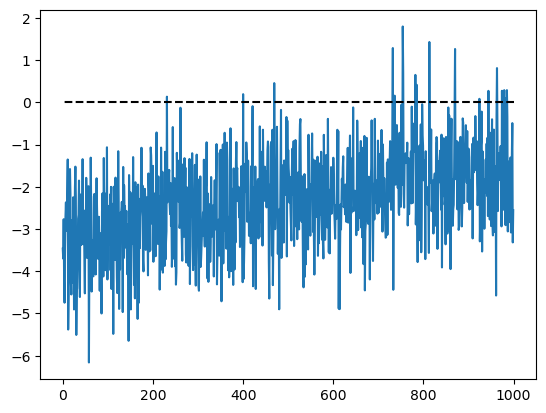

In [21]:
plt.plot(payout)
plt.hlines(0, len(payout), 0, color = 'black', linestyle = 'dashed')

## visualizations

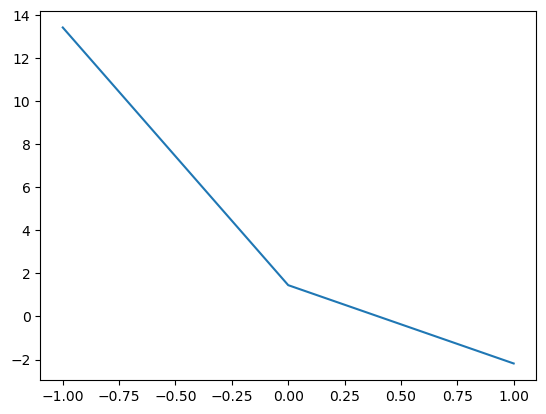

In [22]:
counts = 1. * torch.arange(-1, 2).reshape(-1, 1)
plt.plot(counts, counter_value(counts).detach())

In [23]:
counter_value(counts)

tensor([[13.4347],
        [ 1.4565],
        [-2.1839]], grad_fn=<AddmmBackward0>)

In [24]:
counter_policy(counts)

tensor([[0.3345, 0.4377, 0.2278],
        [0.3345, 0.4369, 0.2286],
        [0.3341, 0.4459, 0.2201]], grad_fn=<SoftmaxBackward0>)

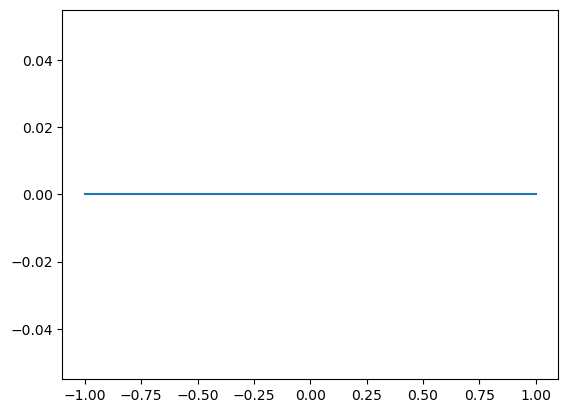

In [25]:
plt.plot(counts, bet_policy(counts).detach().argmax(axis = -1))

In [26]:
all_player = torch.arange(9, 21)
all_dealer = torch.arange(2, 12)

x = 1. * torch.cartesian_prod(all_player, all_dealer)
x = torch.hstack((torch.tensor([0. for _ in x[:,0]]).reshape(-1, 1), x, torch.tensor([0. for _ in x[:,0]]).reshape(-1, 1)))
x.shape

torch.Size([120, 4])

([<matplotlib.axis.YTick at 0x7fc40d858e20>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10'),
  Text(0, 11, '11')])

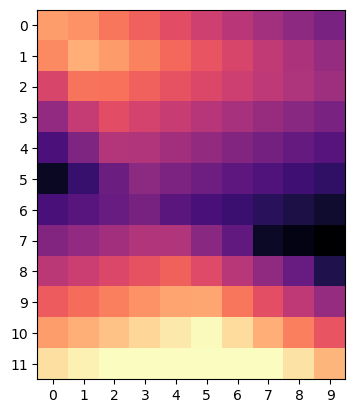

In [27]:
plt.imshow(value(x).reshape(12, 10).detach(), cmap = 'magma')
plt.xticks(all_dealer - 2)
plt.yticks(all_player - 9)

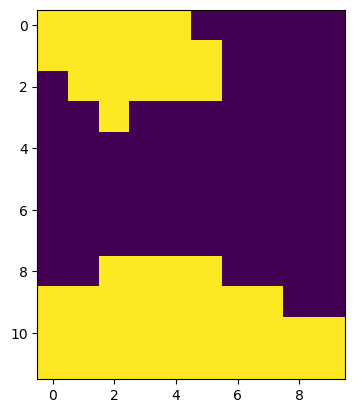

In [28]:
plt.imshow(value(x).reshape(12, 10).detach() > 0)

([<matplotlib.axis.YTick at 0x7fc40e4dc7f0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10'),
  Text(0, 11, '11')])

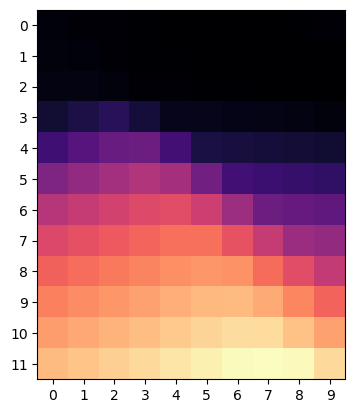

In [29]:
plt.imshow((policy(x)[:,0]).reshape(12, 10).detach(), cmap = 'magma')
plt.xticks(all_dealer - 2)
plt.yticks(all_player - 9)

In [30]:
#plt.imshow(policy(x).argmax(axis = -1).reshape(12, 10).detach(), cmap = 'jet')
#plt.xticks(all_dealer - 2)
#plt.yticks(all_player - 9)

policy(x).argmax(axis = -1).reshape(12, 10).detach()

tensor([[2, 2, 2, 2, 2, 5, 5, 1, 1, 1],
        [2, 2, 2, 2, 2, 5, 5, 5, 1, 1],
        [2, 2, 2, 2, 2, 5, 5, 1, 1, 1],
        [5, 5, 4, 5, 5, 5, 5, 5, 5, 1],
        [4, 4, 4, 4, 4, 5, 5, 5, 5, 5],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 0, 0, 4, 4, 4],
        [4, 4, 0, 0, 0, 0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
# secuurity / insecurity
#plt.imshow(policy(x)[torch.arange(x.shape[0]), policy(x).argmax(axis = -1)].reshape(12, 10).detach(), cmap = 'magma')
#plt.xticks(all_dealer - 2)
#plt.yticks(all_player - 9)

policy(x)[torch.arange(x.shape[0]), policy(x).argmax(axis = -1)].reshape(12, 10).detach()

tensor([[0.2444, 0.2632, 0.2612, 0.2807, 0.2602, 0.2510, 0.2685, 0.2882, 0.3306,
         0.3730],
        [0.2327, 0.2506, 0.2608, 0.2593, 0.2533, 0.2463, 0.2616, 0.2752, 0.2978,
         0.3438],
        [0.2237, 0.2362, 0.2482, 0.2457, 0.2426, 0.2402, 0.2547, 0.2837, 0.3184,
         0.3539],
        [0.2604, 0.2545, 0.2768, 0.2704, 0.3097, 0.3260, 0.3396, 0.3489, 0.3552,
         0.3636],
        [0.3416, 0.4027, 0.4429, 0.4519, 0.3741, 0.3342, 0.3438, 0.3502, 0.3550,
         0.3581],
        [0.4798, 0.5151, 0.5378, 0.5481, 0.5357, 0.4808, 0.3825, 0.3758, 0.3681,
         0.3594],
        [0.5695, 0.5793, 0.5824, 0.5791, 0.5754, 0.5742, 0.5396, 0.4802, 0.4757,
         0.4702],
        [0.5903, 0.5863, 0.5796, 0.5698, 0.5592, 0.5589, 0.5792, 0.5832, 0.5495,
         0.5474],
        [0.5773, 0.5676, 0.5568, 0.5445, 0.5318, 0.5228, 0.5297, 0.5649, 0.5896,
         0.5932],
        [0.5508, 0.5388, 0.5265, 0.5131, 0.4997, 0.5119, 0.5139, 0.5029, 0.5420,
         0.5764],
        [0

## gameplay under this policy

In [32]:
winnings, history = do_games(policy, counter_policy, bet_policy, verbose = True)


Bet: 20.0
Player: 15.0 | Dealer: 4.0
Hitting...
Player: 25.0 | Dealer: 4.0
Player bust!
Player: 25.0 | Dealer: 10.0
Payout: -20.0

Bet: 25.0
Player: 13.0 | Dealer: 3.0
Hitting...
Player: 21.0 | Dealer: 3.0
Player win!
Player: 21.0 | Dealer: 20.0
Payout: 25.0

Bet: 25.0
Player: 8.0 | Dealer: 6.0
Doubling...
Player: 18.0 | Dealer: 6.0
Dealer win!
Player: 18.0 | Dealer: 19.0
Payout: -50.0

Bet: 20.0
Player: 12.0 | Dealer: 3.0
Hitting...
Player: 22.0 | Dealer: 3.0
Player bust!
Player: 22.0 | Dealer: 13.0
Payout: -20.0

Bet: 30.0
Player: 16.0 | Dealer: 4.0
Doubling...
Player: 15.0 | Dealer: 4.0
Dealer win!
Player: 15.0 | Dealer: 19.0
Payout: -60.0

Bet: 10.0
Player: 13.0 | Dealer: 4.0
Standing...
Player: 13.0 | Dealer: 4.0
Dealer bust!
Player: 13.0 | Dealer: 24.0
Payout: 10.0

Bet: 15.0
Player: 6.0 | Dealer: 6.0
Doubling...
Player: 10.0 | Dealer: 6.0
Dealer bust!
Player: 10.0 | Dealer: 24.0
Payout: 30.0

Bet: 35.0
Player: 15.0 | Dealer: 7.0
Standing...
Player: 15.0 | Dealer: 7.0
Dealer win

ValueError: too many values to unpack (expected 2)

In [ ]:
print(winnings)

In [ ]:
counter_policy(1. * torch.arange(2, 12).reshape(-1, 1))